# PTN Template
This notebook serves as a template for single dataset PTN experiments  
It can be run on its own by setting STANDALONE to True (do a find for "STANDALONE" to see where)  
But it is intended to be executed as part of a *papermill.py script. See any of the   
experimentes with a papermill script to get started with that workflow.  

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

    
import os, json, sys, time, random
import numpy as np
import torch
from torch.optim import Adam
from  easydict import EasyDict
import matplotlib.pyplot as plt

from steves_models.steves_ptn import Steves_Prototypical_Network

from steves_utils.lazy_iterable_wrapper import Lazy_Iterable_Wrapper
from steves_utils.iterable_aggregator import Iterable_Aggregator
from steves_utils.ptn_train_eval_test_jig import  PTN_Train_Eval_Test_Jig
from steves_utils.torch_sequential_builder import build_sequential
from steves_utils.torch_utils import get_dataset_metrics, ptn_confusion_by_domain_over_dataloader
from steves_utils.utils_v2 import (per_domain_accuracy_from_confusion, get_datasets_base_path)
from steves_utils.PTN.utils import independent_accuracy_assesment

from steves_utils.stratified_dataset.episodic_accessor import Episodic_Accessor_Factory

from steves_utils.ptn_do_report import (
    get_loss_curve,
    get_results_table,
    get_parameters_table,
    get_domain_accuracies,
)

from steves_utils.transforms import get_chained_transform

# Required Parameters
These are allowed parameters, not defaults
Each of these values need to be present in the injected parameters (the notebook will raise an exception if they are not present)

Papermill uses the cell tag "parameters" to inject the real parameters below this cell.
Enable tags to see what I mean

In [2]:
required_parameters = {
    "experiment_name",
    "lr",
    "device",
    "seed",
    "dataset_seed",
    "labels_source",
    "labels_target",
    "domains_source",
    "domains_target",
    "num_examples_per_domain_per_label_source",
    "num_examples_per_domain_per_label_target",
    "n_shot",
    "n_way",
    "n_query",
    "train_k_factor",
    "val_k_factor",
    "test_k_factor",
    "n_epoch",
    "patience",
    "criteria_for_best",
    "x_transforms_source",
    "x_transforms_target",
    "episode_transforms_source",
    "episode_transforms_target",
    "pickle_name",
    "x_net",
    "NUM_LOGS_PER_EPOCH",
    "BEST_MODEL_PATH",
    "torch_default_dtype"
}

In [3]:


standalone_parameters = {}
standalone_parameters["experiment_name"] = "STANDALONE PTN"
standalone_parameters["lr"] = 0.0001
standalone_parameters["device"] = "cuda"

standalone_parameters["seed"] = 1337
standalone_parameters["dataset_seed"] = 1337


standalone_parameters["num_examples_per_domain_per_label_source"]=100
standalone_parameters["num_examples_per_domain_per_label_target"]=100

standalone_parameters["n_shot"] = 3
standalone_parameters["n_query"]  = 2
standalone_parameters["train_k_factor"] = 1
standalone_parameters["val_k_factor"] = 2
standalone_parameters["test_k_factor"] = 2


standalone_parameters["n_epoch"] = 100

standalone_parameters["patience"] = 10
standalone_parameters["criteria_for_best"] = "target_accuracy"

standalone_parameters["x_transforms_source"] = ["unit_power"]
standalone_parameters["x_transforms_target"] = ["unit_power"]
standalone_parameters["episode_transforms_source"] = []
standalone_parameters["episode_transforms_target"] = []

standalone_parameters["torch_default_dtype"] = "torch.float32" 



standalone_parameters["x_net"] =     [
    {"class": "nnReshape", "kargs": {"shape":[-1, 1, 2, 256]}},
    {"class": "Conv2d", "kargs": { "in_channels":1, "out_channels":256, "kernel_size":(1,7), "bias":False, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":256}},

    {"class": "Conv2d", "kargs": { "in_channels":256, "out_channels":80, "kernel_size":(2,7), "bias":True, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":80}},
    {"class": "Flatten", "kargs": {}},

    {"class": "Linear", "kargs": {"in_features": 80*256, "out_features": 256}}, # 80 units per IQ pair
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm1d", "kargs": {"num_features":256}},

    {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
]

# Parameters relevant to results
# These parameters will basically never need to change
standalone_parameters["NUM_LOGS_PER_EPOCH"] = 10
standalone_parameters["BEST_MODEL_PATH"] = "./best_model.pth"

# uncomment for CORES dataset
from steves_utils.CORES.utils import (
    ALL_NODES,
    ALL_NODES_MINIMUM_1000_EXAMPLES,
    ALL_DAYS
)


standalone_parameters["labels_source"] = ALL_NODES
standalone_parameters["labels_target"] = ALL_NODES

standalone_parameters["domains_source"] = [1]
standalone_parameters["domains_target"] = [2,3,4,5]

standalone_parameters["pickle_name"] = "cores.stratified_ds.2022A.pkl"


# Uncomment these for ORACLE dataset
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )
# standalone_parameters["labels_source"] = ALL_SERIAL_NUMBERS
# standalone_parameters["labels_target"] = ALL_SERIAL_NUMBERS
# standalone_parameters["domains_source"] = [8,20, 38,50]
# standalone_parameters["domains_target"] = [14, 26, 32, 44, 56]
# standalone_parameters["pickle_name"] = "oracle.frame_indexed.stratified_ds.2022A.pkl"
# standalone_parameters["num_examples_per_domain_per_label_source"]=1000
# standalone_parameters["num_examples_per_domain_per_label_target"]=1000

# Uncomment these for Metahan dataset
# standalone_parameters["labels_source"] = list(range(19))
# standalone_parameters["labels_target"] = list(range(19))
# standalone_parameters["domains_source"] = [0]
# standalone_parameters["domains_target"] = [1]
# standalone_parameters["pickle_name"] = "metehan.stratified_ds.2022A.pkl"
# standalone_parameters["n_way"]  = len(standalone_parameters["labels_source"])
# standalone_parameters["num_examples_per_domain_per_label_source"]=200
# standalone_parameters["num_examples_per_domain_per_label_target"]=100


standalone_parameters["n_way"]  = len(standalone_parameters["labels_source"])

In [4]:
# Parameters
parameters = {
    "experiment_name": "baseline_ptn_32bit_oracle.run1.framed",
    "lr": 0.001,
    "device": "cuda",
    "seed": 1337,
    "dataset_seed": 1337,
    "labels_source": [
        "3123D52",
        "3123D65",
        "3123D79",
        "3123D80",
        "3123D54",
        "3123D70",
        "3123D7B",
        "3123D89",
        "3123D58",
        "3123D76",
        "3123D7D",
        "3123EFE",
        "3123D64",
        "3123D78",
        "3123D7E",
        "3124E4A",
    ],
    "labels_target": [
        "3123D52",
        "3123D65",
        "3123D79",
        "3123D80",
        "3123D54",
        "3123D70",
        "3123D7B",
        "3123D89",
        "3123D58",
        "3123D76",
        "3123D7D",
        "3123EFE",
        "3123D64",
        "3123D78",
        "3123D7E",
        "3124E4A",
    ],
    "x_transforms_source": [],
    "x_transforms_target": [],
    "episode_transforms_source": [],
    "episode_transforms_target": [],
    "num_examples_per_domain_per_label_source": 1000,
    "num_examples_per_domain_per_label_target": 1000,
    "n_shot": 3,
    "n_way": 16,
    "n_query": 2,
    "train_k_factor": 1,
    "val_k_factor": 2,
    "test_k_factor": 2,
    "torch_default_dtype": "torch.float32",
    "n_epoch": 50,
    "patience": 3,
    "criteria_for_best": "target_loss",
    "x_net": [
        {"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 1,
                "out_channels": 256,
                "kernel_size": [1, 7],
                "bias": False,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 256}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 256,
                "out_channels": 80,
                "kernel_size": [2, 7],
                "bias": True,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 80}},
        {"class": "Flatten", "kargs": {}},
        {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}},
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm1d", "kargs": {"num_features": 256}},
        {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
    ],
    "NUM_LOGS_PER_EPOCH": 10,
    "BEST_MODEL_PATH": "./best_model.pth",
    "pickle_name": "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl",
    "domains_source": [8, 32, 50],
    "domains_target": [14, 20, 26, 38, 44],
}


In [5]:
# Set this to True if you want to run this template directly
STANDALONE = False
if STANDALONE:
    print("parameters not injected, running with standalone_parameters")
    parameters = standalone_parameters

if not 'parameters' in locals() and not 'parameters' in globals():
    raise Exception("Parameter injection failed")

#Use an easy dict for all the parameters
p = EasyDict(parameters)

supplied_keys = set(p.keys())

if  supplied_keys != required_parameters:
    print("Parameters are incorrect")
    if len(supplied_keys - required_parameters)>0: print("Shouldn't have:", str(supplied_keys - required_parameters))
    if len(required_parameters - supplied_keys)>0: print("Need to have:", str(required_parameters - supplied_keys))
    raise RuntimeError("Parameters are incorrect")



In [6]:
###################################
# Set the RNGs and make it all deterministic
###################################
np.random.seed(p.seed)
random.seed(p.seed)
torch.manual_seed(p.seed)

torch.use_deterministic_algorithms(True) 

In [7]:
###########################################
# The stratified datasets honor this
###########################################
torch.set_default_dtype(eval(p.torch_default_dtype))

In [8]:
###################################
# Build the network(s)
# Note: It's critical to do this AFTER setting the RNG
# (This is due to the randomized initial weights)
###################################
x_net = build_sequential(p.x_net)

In [9]:
start_time_secs = time.time()

In [10]:
###################################
# Build the dataset
###################################

if p.x_transforms_source == []: x_transform_source = None
else: x_transform_source = get_chained_transform(p.x_transforms_source) 

if p.x_transforms_target == []: x_transform_target = None
else: x_transform_target = get_chained_transform(p.x_transforms_target)

if p.episode_transforms_source == []: episode_transform_source = None
else: raise Exception("episode_transform_source not implemented")

if p.episode_transforms_target == []: episode_transform_target = None
else: raise Exception("episode_transform_target not implemented")


eaf_source = Episodic_Accessor_Factory(
    labels=p.labels_source,
    domains=p.domains_source,
    num_examples_per_domain_per_label=p.num_examples_per_domain_per_label_source,
    iterator_seed=p.seed,
    dataset_seed=p.dataset_seed,
    n_shot=p.n_shot,
    n_way=p.n_way,
    n_query=p.n_query,
    train_val_test_k_factors=(p.train_k_factor,p.val_k_factor,p.test_k_factor),
    pickle_path=os.path.join(get_datasets_base_path(), p.pickle_name),
    x_transform_func=x_transform_source,
    example_transform_func=episode_transform_source,
    
)
train_original_source, val_original_source, test_original_source = eaf_source.get_train(), eaf_source.get_val(), eaf_source.get_test()


eaf_target = Episodic_Accessor_Factory(
    labels=p.labels_target,
    domains=p.domains_target,
    num_examples_per_domain_per_label=p.num_examples_per_domain_per_label_target,
    iterator_seed=p.seed,
    dataset_seed=p.dataset_seed,
    n_shot=p.n_shot,
    n_way=p.n_way,
    n_query=p.n_query,
    train_val_test_k_factors=(p.train_k_factor,p.val_k_factor,p.test_k_factor),
    pickle_path=os.path.join(get_datasets_base_path(), p.pickle_name),
    x_transform_func=x_transform_target,
    example_transform_func=episode_transform_target,
)
train_original_target, val_original_target, test_original_target = eaf_target.get_train(), eaf_target.get_val(), eaf_target.get_test()


transform_lambda = lambda ex: ex[1] # Original is (<domain>, <episode>) so we strip down to episode only

train_processed_source = Lazy_Iterable_Wrapper(train_original_source, transform_lambda)
val_processed_source   = Lazy_Iterable_Wrapper(val_original_source, transform_lambda)
test_processed_source  = Lazy_Iterable_Wrapper(test_original_source, transform_lambda)

train_processed_target = Lazy_Iterable_Wrapper(train_original_target, transform_lambda)
val_processed_target   = Lazy_Iterable_Wrapper(val_original_target, transform_lambda)
test_processed_target  = Lazy_Iterable_Wrapper(test_original_target, transform_lambda)

datasets = EasyDict({
    "source": {
        "original": {"train":train_original_source, "val":val_original_source, "test":test_original_source},
        "processed": {"train":train_processed_source, "val":val_processed_source, "test":test_processed_source}
    },
    "target": {
        "original": {"train":train_original_target, "val":val_original_target, "test":test_original_target},
        "processed": {"train":train_processed_target, "val":val_processed_target, "test":test_processed_target}
    },
})

In [11]:
# Some quick unit tests on the data
from steves_utils.transforms import get_average_power, get_average_magnitude

q_x, q_y, s_x, s_y, truth = next(iter(train_processed_source))

assert q_x.dtype == eval(p.torch_default_dtype)
assert s_x.dtype == eval(p.torch_default_dtype)

print("Visually inspect these to see if they line up with expected values given the transforms")
print('x_transforms_source', p.x_transforms_source)
print('x_transforms_target', p.x_transforms_target)
print("Average magnitude, source:", get_average_magnitude(q_x[0].numpy()))
print("Average power, source:", get_average_power(q_x[0].numpy()))

q_x, q_y, s_x, s_y, truth = next(iter(train_processed_target))
print("Average magnitude, target:", get_average_magnitude(q_x[0].numpy()))
print("Average power, target:", get_average_power(q_x[0].numpy()))


Visually inspect these to see if they line up with expected values given the transforms
x_transforms_source []
x_transforms_target []
Average magnitude, source: 0.0053451685
Average power, source: 3.0088388e-05


Average magnitude, target: 0.0031388113
Average power, target: 1.078867e-05


In [12]:
###################################
# Build the model
###################################
model = Steves_Prototypical_Network(x_net, device=p.device, x_shape=(2,256))
optimizer = Adam(params=model.parameters(), lr=p.lr)

(2, 256)


In [13]:
###################################
# train
###################################
jig = PTN_Train_Eval_Test_Jig(model, p.BEST_MODEL_PATH, p.device)

jig.train(
    train_iterable=datasets.source.processed.train,
    source_val_iterable=datasets.source.processed.val,
    target_val_iterable=datasets.target.processed.val,
    num_epochs=p.n_epoch,
    num_logs_per_epoch=p.NUM_LOGS_PER_EPOCH,
    patience=p.patience,
    optimizer=optimizer,
    criteria_for_best=p.criteria_for_best,
)

epoch: 1, [batch: 1 / 420], examples_per_second: 273.7571, train_label_loss: 2.3700, 


epoch: 1, [batch: 42 / 420], examples_per_second: 510.6088, train_label_loss: 1.2223, 


epoch: 1, [batch: 84 / 420], examples_per_second: 508.8957, train_label_loss: 0.7805, 


epoch: 1, [batch: 126 / 420], examples_per_second: 504.3636, train_label_loss: 1.0776, 


epoch: 1, [batch: 168 / 420], examples_per_second: 506.8084, train_label_loss: 0.5847, 


epoch: 1, [batch: 210 / 420], examples_per_second: 511.4246, train_label_loss: 0.3365, 


epoch: 1, [batch: 252 / 420], examples_per_second: 465.4779, train_label_loss: 1.1533, 


epoch: 1, [batch: 294 / 420], examples_per_second: 462.1302, train_label_loss: 0.3717, 


epoch: 1, [batch: 336 / 420], examples_per_second: 465.5951, train_label_loss: 0.2206, 


epoch: 1, [batch: 378 / 420], examples_per_second: 460.1468, train_label_loss: 0.3910, 


epoch: 1, source_val_acc_label: 0.7444, target_val_acc_label: 0.6582, source_val_label_loss: 4.9722, target_val_label_loss: 6.9569, 


New best


epoch: 2, [batch: 1 / 420], examples_per_second: 4.2287, train_label_loss: 0.4742, 


epoch: 2, [batch: 42 / 420], examples_per_second: 463.9725, train_label_loss: 1.4640, 


epoch: 2, [batch: 84 / 420], examples_per_second: 460.4975, train_label_loss: 1.1852, 


epoch: 2, [batch: 126 / 420], examples_per_second: 468.4179, train_label_loss: 0.7087, 


epoch: 2, [batch: 168 / 420], examples_per_second: 467.6752, train_label_loss: 0.9253, 


epoch: 2, [batch: 210 / 420], examples_per_second: 465.9116, train_label_loss: 0.9794, 


epoch: 2, [batch: 252 / 420], examples_per_second: 465.6506, train_label_loss: 0.7070, 


epoch: 2, [batch: 294 / 420], examples_per_second: 466.2172, train_label_loss: 0.5755, 


epoch: 2, [batch: 336 / 420], examples_per_second: 465.2052, train_label_loss: 1.0274, 


epoch: 2, [batch: 378 / 420], examples_per_second: 466.6429, train_label_loss: 0.3085, 


epoch: 2, source_val_acc_label: 0.8028, target_val_acc_label: 0.6820, source_val_label_loss: 0.5615, target_val_label_loss: 1.1575, 


New best


epoch: 3, [batch: 1 / 420], examples_per_second: 4.3884, train_label_loss: 0.5321, 


epoch: 3, [batch: 42 / 420], examples_per_second: 521.9868, train_label_loss: 0.5529, 


epoch: 3, [batch: 84 / 420], examples_per_second: 536.9314, train_label_loss: 0.9060, 


epoch: 3, [batch: 126 / 420], examples_per_second: 544.2889, train_label_loss: 0.5652, 


epoch: 3, [batch: 168 / 420], examples_per_second: 537.5623, train_label_loss: 0.6591, 


epoch: 3, [batch: 210 / 420], examples_per_second: 559.1905, train_label_loss: 0.6436, 


epoch: 3, [batch: 252 / 420], examples_per_second: 542.8211, train_label_loss: 0.6854, 


epoch: 3, [batch: 294 / 420], examples_per_second: 531.9036, train_label_loss: 0.4213, 


epoch: 3, [batch: 336 / 420], examples_per_second: 507.8791, train_label_loss: 0.4815, 


epoch: 3, [batch: 378 / 420], examples_per_second: 504.8816, train_label_loss: 0.3216, 


epoch: 3, source_val_acc_label: 0.8118, target_val_acc_label: 0.7030, source_val_label_loss: 0.5260, target_val_label_loss: 1.1135, 


New best


epoch: 4, [batch: 1 / 420], examples_per_second: 4.4129, train_label_loss: 0.5973, 


epoch: 4, [batch: 42 / 420], examples_per_second: 465.6906, train_label_loss: 0.7420, 


epoch: 4, [batch: 84 / 420], examples_per_second: 465.1973, train_label_loss: 0.6527, 


epoch: 4, [batch: 126 / 420], examples_per_second: 469.3618, train_label_loss: 0.8637, 


epoch: 4, [batch: 168 / 420], examples_per_second: 463.3729, train_label_loss: 0.4905, 


epoch: 4, [batch: 210 / 420], examples_per_second: 469.2044, train_label_loss: 0.1574, 


epoch: 4, [batch: 252 / 420], examples_per_second: 463.9655, train_label_loss: 0.4310, 


epoch: 4, [batch: 294 / 420], examples_per_second: 464.8997, train_label_loss: 0.3301, 


epoch: 4, [batch: 336 / 420], examples_per_second: 462.1870, train_label_loss: 0.8444, 


epoch: 4, [batch: 378 / 420], examples_per_second: 462.3331, train_label_loss: 0.3952, 


epoch: 4, source_val_acc_label: 0.8269, target_val_acc_label: 0.6929, source_val_label_loss: 0.4881, target_val_label_loss: 1.0436, 


New best


epoch: 5, [batch: 1 / 420], examples_per_second: 4.2337, train_label_loss: 0.2428, 


epoch: 5, [batch: 42 / 420], examples_per_second: 465.7588, train_label_loss: 0.6862, 


epoch: 5, [batch: 84 / 420], examples_per_second: 464.3530, train_label_loss: 0.2180, 


epoch: 5, [batch: 126 / 420], examples_per_second: 461.7860, train_label_loss: 0.3955, 


epoch: 5, [batch: 168 / 420], examples_per_second: 464.7610, train_label_loss: 0.3942, 


epoch: 5, [batch: 210 / 420], examples_per_second: 462.3683, train_label_loss: 0.2754, 


epoch: 5, [batch: 252 / 420], examples_per_second: 464.3561, train_label_loss: 0.1980, 


epoch: 5, [batch: 294 / 420], examples_per_second: 483.4690, train_label_loss: 0.4556, 


epoch: 5, [batch: 336 / 420], examples_per_second: 505.6933, train_label_loss: 0.5593, 


epoch: 5, [batch: 378 / 420], examples_per_second: 508.9389, train_label_loss: 0.4075, 


epoch: 5, source_val_acc_label: 0.8198, target_val_acc_label: 0.6847, source_val_label_loss: 0.4936, target_val_label_loss: 1.0776, 


epoch: 6, [batch: 1 / 420], examples_per_second: 4.6702, train_label_loss: 0.3256, 


epoch: 6, [batch: 42 / 420], examples_per_second: 515.4217, train_label_loss: 0.4426, 


epoch: 6, [batch: 84 / 420], examples_per_second: 552.8229, train_label_loss: 0.4656, 


epoch: 6, [batch: 126 / 420], examples_per_second: 467.6039, train_label_loss: 0.3398, 


epoch: 6, [batch: 168 / 420], examples_per_second: 463.0959, train_label_loss: 0.1773, 


epoch: 6, [batch: 210 / 420], examples_per_second: 460.8834, train_label_loss: 0.4758, 


epoch: 6, [batch: 252 / 420], examples_per_second: 464.5744, train_label_loss: 0.3471, 


epoch: 6, [batch: 294 / 420], examples_per_second: 461.8357, train_label_loss: 0.6313, 


epoch: 6, [batch: 336 / 420], examples_per_second: 464.4246, train_label_loss: 0.4343, 


epoch: 6, [batch: 378 / 420], examples_per_second: 463.8761, train_label_loss: 0.5516, 


epoch: 6, source_val_acc_label: 0.8378, target_val_acc_label: 0.7303, source_val_label_loss: 0.4595, target_val_label_loss: 0.9607, 


New best


epoch: 7, [batch: 1 / 420], examples_per_second: 4.2413, train_label_loss: 0.2187, 


epoch: 7, [batch: 42 / 420], examples_per_second: 463.0368, train_label_loss: 0.4880, 


epoch: 7, [batch: 84 / 420], examples_per_second: 463.9760, train_label_loss: 0.5319, 


epoch: 7, [batch: 126 / 420], examples_per_second: 463.8730, train_label_loss: 0.4946, 


epoch: 7, [batch: 168 / 420], examples_per_second: 464.5900, train_label_loss: 0.2656, 


epoch: 7, [batch: 210 / 420], examples_per_second: 460.3032, train_label_loss: 0.1537, 


epoch: 7, [batch: 252 / 420], examples_per_second: 464.7220, train_label_loss: 0.4851, 


epoch: 7, [batch: 294 / 420], examples_per_second: 462.4014, train_label_loss: 0.5888, 


epoch: 7, [batch: 336 / 420], examples_per_second: 464.2815, train_label_loss: 0.5298, 


epoch: 7, [batch: 378 / 420], examples_per_second: 478.0578, train_label_loss: 0.5162, 


epoch: 7, source_val_acc_label: 0.8589, target_val_acc_label: 0.7445, source_val_label_loss: 0.3988, target_val_label_loss: 0.9786, 


epoch: 8, [batch: 1 / 420], examples_per_second: 4.6652, train_label_loss: 0.2466, 


epoch: 8, [batch: 42 / 420], examples_per_second: 545.7027, train_label_loss: 0.3947, 


epoch: 8, [batch: 84 / 420], examples_per_second: 557.9843, train_label_loss: 0.2635, 


epoch: 8, [batch: 126 / 420], examples_per_second: 552.7856, train_label_loss: 0.6546, 


epoch: 8, [batch: 168 / 420], examples_per_second: 520.9109, train_label_loss: 0.1681, 


epoch: 8, [batch: 210 / 420], examples_per_second: 504.7687, train_label_loss: 0.6596, 


epoch: 8, [batch: 252 / 420], examples_per_second: 508.7535, train_label_loss: 0.7806, 


epoch: 8, [batch: 294 / 420], examples_per_second: 504.1241, train_label_loss: 0.5272, 


epoch: 8, [batch: 336 / 420], examples_per_second: 568.6788, train_label_loss: 0.2524, 


epoch: 8, [batch: 378 / 420], examples_per_second: 463.6806, train_label_loss: 0.3676, 


epoch: 8, source_val_acc_label: 0.8712, target_val_acc_label: 0.7478, source_val_label_loss: 0.3724, target_val_label_loss: 1.0186, 


epoch: 9, [batch: 1 / 420], examples_per_second: 4.2400, train_label_loss: 0.2440, 


epoch: 9, [batch: 42 / 420], examples_per_second: 465.6346, train_label_loss: 0.2193, 


epoch: 9, [batch: 84 / 420], examples_per_second: 466.7927, train_label_loss: 0.2609, 


epoch: 9, [batch: 126 / 420], examples_per_second: 463.9986, train_label_loss: 0.2197, 


epoch: 9, [batch: 168 / 420], examples_per_second: 463.2461, train_label_loss: 0.2547, 


epoch: 9, [batch: 210 / 420], examples_per_second: 482.3478, train_label_loss: 0.4705, 


epoch: 9, [batch: 252 / 420], examples_per_second: 493.3556, train_label_loss: 0.2440, 


epoch: 9, [batch: 294 / 420], examples_per_second: 495.2565, train_label_loss: 0.2460, 


epoch: 9, [batch: 336 / 420], examples_per_second: 486.1308, train_label_loss: 0.3675, 


epoch: 9, [batch: 378 / 420], examples_per_second: 486.9047, train_label_loss: 0.3789, 


epoch: 9, source_val_acc_label: 0.8760, target_val_acc_label: 0.7847, source_val_label_loss: 0.3593, target_val_label_loss: 0.8970, 


New best


epoch: 10, [batch: 1 / 420], examples_per_second: 4.5534, train_label_loss: 0.2490, 


epoch: 10, [batch: 42 / 420], examples_per_second: 462.2606, train_label_loss: 0.2361, 


epoch: 10, [batch: 84 / 420], examples_per_second: 463.0498, train_label_loss: 0.3323, 


epoch: 10, [batch: 126 / 420], examples_per_second: 464.4945, train_label_loss: 0.1209, 


epoch: 10, [batch: 168 / 420], examples_per_second: 463.0567, train_label_loss: 0.4398, 


epoch: 10, [batch: 210 / 420], examples_per_second: 499.1942, train_label_loss: 0.3077, 


epoch: 10, [batch: 252 / 420], examples_per_second: 507.8452, train_label_loss: 0.1623, 


epoch: 10, [batch: 294 / 420], examples_per_second: 507.2941, train_label_loss: 0.0631, 


epoch: 10, [batch: 336 / 420], examples_per_second: 517.2899, train_label_loss: 0.1456, 


epoch: 10, [batch: 378 / 420], examples_per_second: 508.6544, train_label_loss: 0.3063, 


epoch: 10, source_val_acc_label: 0.9078, target_val_acc_label: 0.8325, source_val_label_loss: 0.2700, target_val_label_loss: 0.7208, 


New best


epoch: 11, [batch: 1 / 420], examples_per_second: 4.6888, train_label_loss: 0.2268, 


epoch: 11, [batch: 42 / 420], examples_per_second: 466.3398, train_label_loss: 0.2476, 


epoch: 11, [batch: 84 / 420], examples_per_second: 467.0583, train_label_loss: 0.3410, 


epoch: 11, [batch: 126 / 420], examples_per_second: 467.7989, train_label_loss: 0.3319, 


epoch: 11, [batch: 168 / 420], examples_per_second: 467.6495, train_label_loss: 0.1826, 


epoch: 11, [batch: 210 / 420], examples_per_second: 466.4846, train_label_loss: 0.3724, 


epoch: 11, [batch: 252 / 420], examples_per_second: 470.4237, train_label_loss: 0.2326, 


epoch: 11, [batch: 294 / 420], examples_per_second: 466.1611, train_label_loss: 0.1499, 


epoch: 11, [batch: 336 / 420], examples_per_second: 466.5074, train_label_loss: 0.2845, 


epoch: 11, [batch: 378 / 420], examples_per_second: 465.7008, train_label_loss: 0.1178, 


epoch: 11, source_val_acc_label: 0.9153, target_val_acc_label: 0.8398, source_val_label_loss: 0.2486, target_val_label_loss: 0.6915, 


New best


epoch: 12, [batch: 1 / 420], examples_per_second: 4.2410, train_label_loss: 0.2260, 


epoch: 12, [batch: 42 / 420], examples_per_second: 466.4797, train_label_loss: 0.1473, 


epoch: 12, [batch: 84 / 420], examples_per_second: 466.8967, train_label_loss: 0.1904, 


epoch: 12, [batch: 126 / 420], examples_per_second: 468.0621, train_label_loss: 0.3283, 


epoch: 12, [batch: 168 / 420], examples_per_second: 467.0616, train_label_loss: 0.0581, 


epoch: 12, [batch: 210 / 420], examples_per_second: 466.7115, train_label_loss: 0.1603, 


epoch: 12, [batch: 252 / 420], examples_per_second: 484.0093, train_label_loss: 0.2008, 


epoch: 12, [batch: 294 / 420], examples_per_second: 490.0788, train_label_loss: 0.2150, 


epoch: 12, [batch: 336 / 420], examples_per_second: 488.5356, train_label_loss: 0.1732, 


epoch: 12, [batch: 378 / 420], examples_per_second: 492.4389, train_label_loss: 0.1953, 


epoch: 12, source_val_acc_label: 0.9043, target_val_acc_label: 0.8317, source_val_label_loss: 0.2664, target_val_label_loss: 0.6921, 


epoch: 13, [batch: 1 / 420], examples_per_second: 4.8477, train_label_loss: 0.1241, 


epoch: 13, [batch: 42 / 420], examples_per_second: 539.4450, train_label_loss: 0.4253, 


epoch: 13, [batch: 84 / 420], examples_per_second: 539.8528, train_label_loss: 0.0259, 


epoch: 13, [batch: 126 / 420], examples_per_second: 540.2540, train_label_loss: 0.1183, 


epoch: 13, [batch: 168 / 420], examples_per_second: 539.9681, train_label_loss: 0.3279, 


epoch: 13, [batch: 210 / 420], examples_per_second: 535.7172, train_label_loss: 0.0972, 


epoch: 13, [batch: 252 / 420], examples_per_second: 573.4022, train_label_loss: 0.4237, 


epoch: 13, [batch: 294 / 420], examples_per_second: 489.7913, train_label_loss: 0.3838, 


epoch: 13, [batch: 336 / 420], examples_per_second: 490.7089, train_label_loss: 0.3047, 


epoch: 13, [batch: 378 / 420], examples_per_second: 489.8449, train_label_loss: 0.2164, 


epoch: 13, source_val_acc_label: 0.9248, target_val_acc_label: 0.8448, source_val_label_loss: 0.2222, target_val_label_loss: 0.6434, 


New best


epoch: 14, [batch: 1 / 420], examples_per_second: 4.4955, train_label_loss: 0.2079, 


epoch: 14, [batch: 42 / 420], examples_per_second: 491.5218, train_label_loss: 0.1737, 


epoch: 14, [batch: 84 / 420], examples_per_second: 488.6190, train_label_loss: 0.3457, 


epoch: 14, [batch: 126 / 420], examples_per_second: 493.4805, train_label_loss: 0.1530, 


epoch: 14, [batch: 168 / 420], examples_per_second: 487.1221, train_label_loss: 0.1803, 


epoch: 14, [batch: 210 / 420], examples_per_second: 485.3905, train_label_loss: 0.2245, 


epoch: 14, [batch: 252 / 420], examples_per_second: 488.5911, train_label_loss: 0.1757, 


epoch: 14, [batch: 294 / 420], examples_per_second: 485.3484, train_label_loss: 0.1643, 


epoch: 14, [batch: 336 / 420], examples_per_second: 492.4414, train_label_loss: 0.1995, 


epoch: 14, [batch: 378 / 420], examples_per_second: 485.8309, train_label_loss: 0.2285, 


epoch: 14, source_val_acc_label: 0.9240, target_val_acc_label: 0.8445, source_val_label_loss: 0.2151, target_val_label_loss: 0.6382, 


New best


epoch: 15, [batch: 1 / 420], examples_per_second: 4.4616, train_label_loss: 0.1220, 


epoch: 15, [batch: 42 / 420], examples_per_second: 487.6507, train_label_loss: 0.2283, 


epoch: 15, [batch: 84 / 420], examples_per_second: 495.7534, train_label_loss: 0.1248, 


epoch: 15, [batch: 126 / 420], examples_per_second: 536.2518, train_label_loss: 0.4619, 


epoch: 15, [batch: 168 / 420], examples_per_second: 537.8228, train_label_loss: 0.0663, 


epoch: 15, [batch: 210 / 420], examples_per_second: 569.9840, train_label_loss: 0.0511, 


epoch: 15, [batch: 252 / 420], examples_per_second: 675.7664, train_label_loss: 0.2358, 


epoch: 15, [batch: 294 / 420], examples_per_second: 633.0945, train_label_loss: 0.1328, 


epoch: 15, [batch: 336 / 420], examples_per_second: 643.6034, train_label_loss: 0.2218, 


epoch: 15, [batch: 378 / 420], examples_per_second: 646.4816, train_label_loss: 0.1945, 


epoch: 15, source_val_acc_label: 0.9264, target_val_acc_label: 0.8429, source_val_label_loss: 0.2070, target_val_label_loss: 0.6614, 


epoch: 16, [batch: 1 / 420], examples_per_second: 4.8234, train_label_loss: 0.1052, 


epoch: 16, [batch: 42 / 420], examples_per_second: 462.7778, train_label_loss: 0.2409, 


epoch: 16, [batch: 84 / 420], examples_per_second: 461.8740, train_label_loss: 0.1524, 


epoch: 16, [batch: 126 / 420], examples_per_second: 463.9713, train_label_loss: 0.0878, 


epoch: 16, [batch: 168 / 420], examples_per_second: 461.4843, train_label_loss: 0.1784, 


epoch: 16, [batch: 210 / 420], examples_per_second: 460.6977, train_label_loss: 0.1371, 


epoch: 16, [batch: 252 / 420], examples_per_second: 463.7885, train_label_loss: 0.1358, 


epoch: 16, [batch: 294 / 420], examples_per_second: 461.5989, train_label_loss: 0.1706, 


epoch: 16, [batch: 336 / 420], examples_per_second: 463.2216, train_label_loss: 0.1530, 


epoch: 16, [batch: 378 / 420], examples_per_second: 462.6163, train_label_loss: 0.1873, 


epoch: 16, source_val_acc_label: 0.9309, target_val_acc_label: 0.8573, source_val_label_loss: 0.1948, target_val_label_loss: 0.6129, 


New best


epoch: 17, [batch: 1 / 420], examples_per_second: 4.2305, train_label_loss: 0.1667, 


epoch: 17, [batch: 42 / 420], examples_per_second: 467.2486, train_label_loss: 0.1883, 


epoch: 17, [batch: 84 / 420], examples_per_second: 466.1645, train_label_loss: 0.2431, 


epoch: 17, [batch: 126 / 420], examples_per_second: 465.5098, train_label_loss: 0.1208, 


epoch: 17, [batch: 168 / 420], examples_per_second: 463.5579, train_label_loss: 0.0877, 


epoch: 17, [batch: 210 / 420], examples_per_second: 461.3013, train_label_loss: 0.3156, 


epoch: 17, [batch: 252 / 420], examples_per_second: 462.9650, train_label_loss: 0.0935, 


epoch: 17, [batch: 294 / 420], examples_per_second: 463.7419, train_label_loss: 0.2744, 


epoch: 17, [batch: 336 / 420], examples_per_second: 459.4078, train_label_loss: 0.3739, 


epoch: 17, [batch: 378 / 420], examples_per_second: 495.2285, train_label_loss: 0.4341, 


epoch: 17, source_val_acc_label: 0.9160, target_val_acc_label: 0.8434, source_val_label_loss: 0.2322, target_val_label_loss: 0.6134, 


epoch: 18, [batch: 1 / 420], examples_per_second: 4.6124, train_label_loss: 0.0576, 


epoch: 18, [batch: 42 / 420], examples_per_second: 513.3712, train_label_loss: 0.1588, 


epoch: 18, [batch: 84 / 420], examples_per_second: 517.3351, train_label_loss: 0.1766, 


epoch: 18, [batch: 126 / 420], examples_per_second: 514.1790, train_label_loss: 0.1236, 


epoch: 18, [batch: 168 / 420], examples_per_second: 552.9898, train_label_loss: 0.3157, 


epoch: 18, [batch: 210 / 420], examples_per_second: 467.3492, train_label_loss: 0.0716, 


epoch: 18, [batch: 252 / 420], examples_per_second: 465.8992, train_label_loss: 0.1059, 


epoch: 18, [batch: 294 / 420], examples_per_second: 466.2351, train_label_loss: 0.0814, 


epoch: 18, [batch: 336 / 420], examples_per_second: 465.3489, train_label_loss: 0.1449, 


epoch: 18, [batch: 378 / 420], examples_per_second: 462.8157, train_label_loss: 0.1290, 


epoch: 18, source_val_acc_label: 0.9134, target_val_acc_label: 0.8268, source_val_label_loss: 0.2405, target_val_label_loss: 0.6412, 


epoch: 19, [batch: 1 / 420], examples_per_second: 4.2221, train_label_loss: 0.1402, 


epoch: 19, [batch: 42 / 420], examples_per_second: 466.2307, train_label_loss: 0.1346, 


epoch: 19, [batch: 84 / 420], examples_per_second: 464.4350, train_label_loss: 0.0896, 


epoch: 19, [batch: 126 / 420], examples_per_second: 467.1447, train_label_loss: 0.2799, 


epoch: 19, [batch: 168 / 420], examples_per_second: 466.4253, train_label_loss: 0.3487, 


epoch: 19, [batch: 210 / 420], examples_per_second: 467.3569, train_label_loss: 0.1548, 


epoch: 19, [batch: 252 / 420], examples_per_second: 467.7723, train_label_loss: 0.1619, 


epoch: 19, [batch: 294 / 420], examples_per_second: 465.8295, train_label_loss: 0.1384, 


epoch: 19, [batch: 336 / 420], examples_per_second: 466.6785, train_label_loss: 0.1715, 


epoch: 19, [batch: 378 / 420], examples_per_second: 465.4456, train_label_loss: 0.0813, 


epoch: 19, source_val_acc_label: 0.9354, target_val_acc_label: 0.8689, source_val_label_loss: 0.1891, target_val_label_loss: 0.5785, 


New best


epoch: 20, [batch: 1 / 420], examples_per_second: 4.2597, train_label_loss: 0.1363, 


epoch: 20, [batch: 42 / 420], examples_per_second: 545.5933, train_label_loss: 0.1501, 


epoch: 20, [batch: 84 / 420], examples_per_second: 539.6042, train_label_loss: 0.0945, 


epoch: 20, [batch: 126 / 420], examples_per_second: 540.3612, train_label_loss: 0.2487, 


epoch: 20, [batch: 168 / 420], examples_per_second: 556.7302, train_label_loss: 0.2652, 


epoch: 20, [batch: 210 / 420], examples_per_second: 537.3092, train_label_loss: 0.2550, 


epoch: 20, [batch: 252 / 420], examples_per_second: 538.1456, train_label_loss: 0.1661, 


epoch: 20, [batch: 294 / 420], examples_per_second: 536.5651, train_label_loss: 0.0591, 


epoch: 20, [batch: 336 / 420], examples_per_second: 554.7621, train_label_loss: 0.0342, 


epoch: 20, [batch: 378 / 420], examples_per_second: 515.6787, train_label_loss: 0.1601, 


epoch: 20, source_val_acc_label: 0.9339, target_val_acc_label: 0.8762, source_val_label_loss: 0.1869, target_val_label_loss: 0.5450, 


New best


epoch: 21, [batch: 1 / 420], examples_per_second: 4.3422, train_label_loss: 0.1433, 


epoch: 21, [batch: 42 / 420], examples_per_second: 476.9107, train_label_loss: 0.4636, 


epoch: 21, [batch: 84 / 420], examples_per_second: 491.6815, train_label_loss: 0.2276, 


epoch: 21, [batch: 126 / 420], examples_per_second: 493.0974, train_label_loss: 0.2981, 


epoch: 21, [batch: 168 / 420], examples_per_second: 487.4252, train_label_loss: 0.0262, 


epoch: 21, [batch: 210 / 420], examples_per_second: 491.5865, train_label_loss: 0.3545, 


epoch: 21, [batch: 252 / 420], examples_per_second: 488.9560, train_label_loss: 0.0140, 


epoch: 21, [batch: 294 / 420], examples_per_second: 490.7505, train_label_loss: 0.0424, 


epoch: 21, [batch: 336 / 420], examples_per_second: 489.1100, train_label_loss: 0.0809, 


epoch: 21, [batch: 378 / 420], examples_per_second: 492.6420, train_label_loss: 0.1831, 


epoch: 21, source_val_acc_label: 0.9267, target_val_acc_label: 0.8606, source_val_label_loss: 0.2105, target_val_label_loss: 0.5760, 


epoch: 22, [batch: 1 / 420], examples_per_second: 4.3848, train_label_loss: 0.1318, 


epoch: 22, [batch: 42 / 420], examples_per_second: 463.1715, train_label_loss: 0.3695, 


epoch: 22, [batch: 84 / 420], examples_per_second: 464.8612, train_label_loss: 0.1689, 


epoch: 22, [batch: 126 / 420], examples_per_second: 461.6555, train_label_loss: 0.2507, 


epoch: 22, [batch: 168 / 420], examples_per_second: 463.2162, train_label_loss: 0.4283, 


epoch: 22, [batch: 210 / 420], examples_per_second: 463.3171, train_label_loss: 0.1223, 


epoch: 22, [batch: 252 / 420], examples_per_second: 463.1409, train_label_loss: 0.0914, 


epoch: 22, [batch: 294 / 420], examples_per_second: 509.9590, train_label_loss: 0.0550, 


epoch: 22, [batch: 336 / 420], examples_per_second: 506.2241, train_label_loss: 0.1506, 


epoch: 22, [batch: 378 / 420], examples_per_second: 504.4013, train_label_loss: 0.1984, 


epoch: 22, source_val_acc_label: 0.9344, target_val_acc_label: 0.8623, source_val_label_loss: 0.1822, target_val_label_loss: 0.5412, 


New best


epoch: 23, [batch: 1 / 420], examples_per_second: 4.6316, train_label_loss: 0.2365, 


epoch: 23, [batch: 42 / 420], examples_per_second: 510.6383, train_label_loss: 0.1431, 


epoch: 23, [batch: 84 / 420], examples_per_second: 515.7327, train_label_loss: 0.2262, 


epoch: 23, [batch: 126 / 420], examples_per_second: 464.5242, train_label_loss: 0.1782, 


epoch: 23, [batch: 168 / 420], examples_per_second: 463.9957, train_label_loss: 0.1490, 


epoch: 23, [batch: 210 / 420], examples_per_second: 465.9201, train_label_loss: 0.2017, 


epoch: 23, [batch: 252 / 420], examples_per_second: 462.1152, train_label_loss: 0.2743, 


epoch: 23, [batch: 294 / 420], examples_per_second: 463.3837, train_label_loss: 0.1540, 


epoch: 23, [batch: 336 / 420], examples_per_second: 463.0682, train_label_loss: 0.1008, 


epoch: 23, [batch: 378 / 420], examples_per_second: 463.5993, train_label_loss: 0.2530, 


epoch: 23, source_val_acc_label: 0.9332, target_val_acc_label: 0.8688, source_val_label_loss: 0.1870, target_val_label_loss: 0.5105, 


New best


epoch: 24, [batch: 1 / 420], examples_per_second: 4.2284, train_label_loss: 0.1401, 


epoch: 24, [batch: 42 / 420], examples_per_second: 461.4929, train_label_loss: 0.3386, 


epoch: 24, [batch: 84 / 420], examples_per_second: 463.3372, train_label_loss: 0.2287, 


epoch: 24, [batch: 126 / 420], examples_per_second: 465.9449, train_label_loss: 0.0389, 


epoch: 24, [batch: 168 / 420], examples_per_second: 464.5541, train_label_loss: 0.4529, 


epoch: 24, [batch: 210 / 420], examples_per_second: 462.5358, train_label_loss: 0.1831, 


epoch: 24, [batch: 252 / 420], examples_per_second: 463.2902, train_label_loss: 0.0744, 


epoch: 24, [batch: 294 / 420], examples_per_second: 465.6871, train_label_loss: 0.1010, 


epoch: 24, [batch: 336 / 420], examples_per_second: 461.0267, train_label_loss: 0.1840, 


epoch: 24, [batch: 378 / 420], examples_per_second: 463.2231, train_label_loss: 0.0259, 


epoch: 24, source_val_acc_label: 0.9316, target_val_acc_label: 0.8697, source_val_label_loss: 0.1923, target_val_label_loss: 0.5253, 


epoch: 25, [batch: 1 / 420], examples_per_second: 4.6680, train_label_loss: 0.2440, 


epoch: 25, [batch: 42 / 420], examples_per_second: 535.4020, train_label_loss: 0.1356, 


epoch: 25, [batch: 84 / 420], examples_per_second: 558.4404, train_label_loss: 0.2276, 


epoch: 25, [batch: 126 / 420], examples_per_second: 536.6910, train_label_loss: 0.0946, 


epoch: 25, [batch: 168 / 420], examples_per_second: 541.7283, train_label_loss: 0.1494, 


epoch: 25, [batch: 210 / 420], examples_per_second: 556.6844, train_label_loss: 0.0423, 


epoch: 25, [batch: 252 / 420], examples_per_second: 505.9188, train_label_loss: 0.0486, 


epoch: 25, [batch: 294 / 420], examples_per_second: 504.9906, train_label_loss: 0.3077, 


epoch: 25, [batch: 336 / 420], examples_per_second: 520.6782, train_label_loss: 0.0994, 


epoch: 25, [batch: 378 / 420], examples_per_second: 464.2512, train_label_loss: 0.2844, 


epoch: 25, source_val_acc_label: 0.9370, target_val_acc_label: 0.8640, source_val_label_loss: 0.1885, target_val_label_loss: 0.4949, 


New best


epoch: 26, [batch: 1 / 420], examples_per_second: 4.2355, train_label_loss: 0.1076, 


epoch: 26, [batch: 42 / 420], examples_per_second: 464.3849, train_label_loss: 0.1484, 


epoch: 26, [batch: 84 / 420], examples_per_second: 465.2569, train_label_loss: 0.1920, 


epoch: 26, [batch: 126 / 420], examples_per_second: 463.4155, train_label_loss: 0.0580, 


epoch: 26, [batch: 168 / 420], examples_per_second: 460.2686, train_label_loss: 0.1765, 


epoch: 26, [batch: 210 / 420], examples_per_second: 464.3077, train_label_loss: 0.1430, 


epoch: 26, [batch: 252 / 420], examples_per_second: 462.7810, train_label_loss: 0.2244, 


epoch: 26, [batch: 294 / 420], examples_per_second: 465.1034, train_label_loss: 0.0925, 


epoch: 26, [batch: 336 / 420], examples_per_second: 463.6747, train_label_loss: 0.6107, 


epoch: 26, [batch: 378 / 420], examples_per_second: 465.3042, train_label_loss: 0.0621, 


epoch: 26, source_val_acc_label: 0.9427, target_val_acc_label: 0.8702, source_val_label_loss: 0.1718, target_val_label_loss: 0.5060, 


epoch: 27, [batch: 1 / 420], examples_per_second: 4.2291, train_label_loss: 0.0914, 


epoch: 27, [batch: 42 / 420], examples_per_second: 465.2702, train_label_loss: 0.0933, 


epoch: 27, [batch: 84 / 420], examples_per_second: 466.9217, train_label_loss: 0.0520, 


epoch: 27, [batch: 126 / 420], examples_per_second: 466.5679, train_label_loss: 0.0482, 


epoch: 27, [batch: 168 / 420], examples_per_second: 486.0340, train_label_loss: 0.3472, 


epoch: 27, [batch: 210 / 420], examples_per_second: 507.0697, train_label_loss: 0.1712, 


epoch: 27, [batch: 252 / 420], examples_per_second: 505.3404, train_label_loss: 0.0647, 


epoch: 27, [batch: 294 / 420], examples_per_second: 505.6722, train_label_loss: 0.2165, 


epoch: 27, [batch: 336 / 420], examples_per_second: 519.8664, train_label_loss: 0.0753, 


epoch: 27, [batch: 378 / 420], examples_per_second: 507.7666, train_label_loss: 0.0760, 


epoch: 27, source_val_acc_label: 0.9339, target_val_acc_label: 0.8577, source_val_label_loss: 0.1910, target_val_label_loss: 0.5336, 


epoch: 28, [batch: 1 / 420], examples_per_second: 4.6928, train_label_loss: 0.1539, 


epoch: 28, [batch: 42 / 420], examples_per_second: 515.6838, train_label_loss: 0.0712, 


epoch: 28, [batch: 84 / 420], examples_per_second: 507.8826, train_label_loss: 0.2153, 


epoch: 28, [batch: 126 / 420], examples_per_second: 519.3642, train_label_loss: 0.0888, 


epoch: 28, [batch: 168 / 420], examples_per_second: 507.9017, train_label_loss: 0.0165, 


epoch: 28, [batch: 210 / 420], examples_per_second: 507.4953, train_label_loss: 0.0348, 


epoch: 28, [batch: 252 / 420], examples_per_second: 507.8130, train_label_loss: 0.0407, 


epoch: 28, [batch: 294 / 420], examples_per_second: 504.4222, train_label_loss: 0.1072, 


epoch: 28, [batch: 336 / 420], examples_per_second: 506.0677, train_label_loss: 0.2012, 


epoch: 28, [batch: 378 / 420], examples_per_second: 525.5829, train_label_loss: 0.1225, 


epoch: 28, source_val_acc_label: 0.9394, target_val_acc_label: 0.8564, source_val_label_loss: 0.1706, target_val_label_loss: 0.5504, 


epoch: 29, [batch: 1 / 420], examples_per_second: 4.6375, train_label_loss: 0.1898, 


epoch: 29, [batch: 42 / 420], examples_per_second: 507.7029, train_label_loss: 0.0831, 


epoch: 29, [batch: 84 / 420], examples_per_second: 507.0869, train_label_loss: 0.0435, 


epoch: 29, [batch: 126 / 420], examples_per_second: 505.6283, train_label_loss: 0.1203, 


epoch: 29, [batch: 168 / 420], examples_per_second: 534.3264, train_label_loss: 0.1793, 


epoch: 29, [batch: 210 / 420], examples_per_second: 505.7291, train_label_loss: 0.1293, 


epoch: 29, [batch: 252 / 420], examples_per_second: 507.7862, train_label_loss: 0.0212, 


epoch: 29, [batch: 294 / 420], examples_per_second: 509.8125, train_label_loss: 0.1295, 


epoch: 29, [batch: 336 / 420], examples_per_second: 527.1464, train_label_loss: 0.0634, 


epoch: 29, [batch: 378 / 420], examples_per_second: 531.0729, train_label_loss: 0.0503, 


epoch: 29, source_val_acc_label: 0.9342, target_val_acc_label: 0.8542, source_val_label_loss: 0.1799, target_val_label_loss: 0.5443, 


Patience (3) exhausted


In [14]:
total_experiment_time_secs = time.time() - start_time_secs

In [15]:
###################################
# Evaluate the model
###################################
source_test_label_accuracy, source_test_label_loss = jig.test(datasets.source.processed.test)
target_test_label_accuracy, target_test_label_loss = jig.test(datasets.target.processed.test)

source_val_label_accuracy, source_val_label_loss = jig.test(datasets.source.processed.val)
target_val_label_accuracy, target_val_label_loss = jig.test(datasets.target.processed.val)

history = jig.get_history()

total_epochs_trained = len(history["epoch_indices"])

val_dl = Iterable_Aggregator((datasets.source.original.val,datasets.target.original.val))

confusion = ptn_confusion_by_domain_over_dataloader(model, p.device, val_dl)
per_domain_accuracy = per_domain_accuracy_from_confusion(confusion)

# Add a key to per_domain_accuracy for if it was a source domain
for domain, accuracy in per_domain_accuracy.items():
    per_domain_accuracy[domain] = {
        "accuracy": accuracy,
        "source?": domain in p.domains_source
    }

# Do an independent accuracy assesment JUST TO BE SURE!
# _source_test_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.test, p.device)
# _target_test_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.test, p.device)
# _source_val_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.val, p.device)
# _target_val_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.val, p.device)

# assert(_source_test_label_accuracy == source_test_label_accuracy)
# assert(_target_test_label_accuracy == target_test_label_accuracy)
# assert(_source_val_label_accuracy == source_val_label_accuracy)
# assert(_target_val_label_accuracy == target_val_label_accuracy)

experiment = {
    "experiment_name": p.experiment_name,
    "parameters": dict(p),
    "results": {
        "source_test_label_accuracy": source_test_label_accuracy,
        "source_test_label_loss": source_test_label_loss,
        "target_test_label_accuracy": target_test_label_accuracy,
        "target_test_label_loss": target_test_label_loss,
        "source_val_label_accuracy": source_val_label_accuracy,
        "source_val_label_loss": source_val_label_loss,
        "target_val_label_accuracy": target_val_label_accuracy,
        "target_val_label_loss": target_val_label_loss,
        "total_epochs_trained": total_epochs_trained,
        "total_experiment_time_secs": total_experiment_time_secs,
        "confusion": confusion,
        "per_domain_accuracy": per_domain_accuracy,
    },
    "history": history,
    "dataset_metrics": get_dataset_metrics(datasets, "ptn"),
}

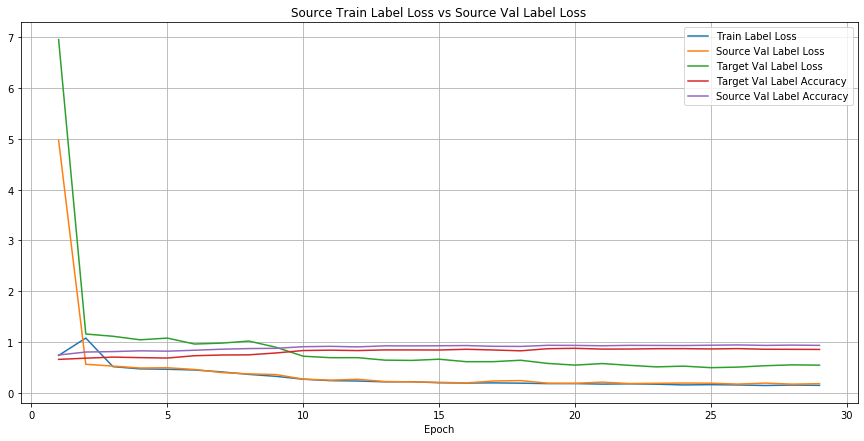

In [16]:
ax = get_loss_curve(experiment)
plt.show()

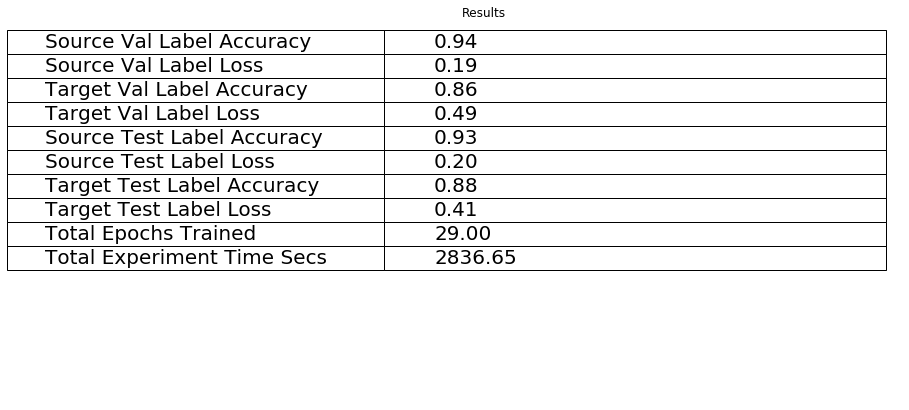

In [17]:
get_results_table(experiment)

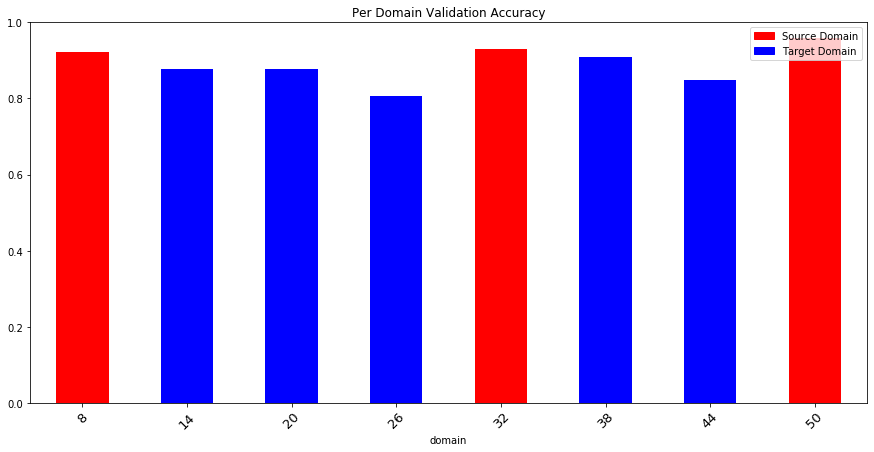

In [18]:
get_domain_accuracies(experiment)

In [19]:
print("Source Test Label Accuracy:", experiment["results"]["source_test_label_accuracy"], "Target Test Label Accuracy:", experiment["results"]["target_test_label_accuracy"])
print("Source Val Label Accuracy:", experiment["results"]["source_val_label_accuracy"], "Target Val Label Accuracy:", experiment["results"]["target_val_label_accuracy"])

Source Test Label Accuracy: 0.9326388888888889 Target Test Label Accuracy: 0.8792708333333333
Source Val Label Accuracy: 0.9369791666666667 Target Val Label Accuracy: 0.8639583333333334


In [20]:
json.dumps(experiment)

'{"experiment_name": "baseline_ptn_32bit_oracle.run1.framed", "parameters": {"experiment_name": "baseline_ptn_32bit_oracle.run1.framed", "lr": 0.001, "device": "cuda", "seed": 1337, "dataset_seed": 1337, "labels_source": ["3123D52", "3123D65", "3123D79", "3123D80", "3123D54", "3123D70", "3123D7B", "3123D89", "3123D58", "3123D76", "3123D7D", "3123EFE", "3123D64", "3123D78", "3123D7E", "3124E4A"], "labels_target": ["3123D52", "3123D65", "3123D79", "3123D80", "3123D54", "3123D70", "3123D7B", "3123D89", "3123D58", "3123D76", "3123D7D", "3123EFE", "3123D64", "3123D78", "3123D7E", "3124E4A"], "x_transforms_source": [], "x_transforms_target": [], "episode_transforms_source": [], "episode_transforms_target": [], "num_examples_per_domain_per_label_source": 1000, "num_examples_per_domain_per_label_target": 1000, "n_shot": 3, "n_way": 16, "n_query": 2, "train_k_factor": 1, "val_k_factor": 2, "test_k_factor": 2, "torch_default_dtype": "torch.float32", "n_epoch": 50, "patience": 3, "criteria_for_be